# Overview
This notebook is intended to demonstrate the _quarter-five spot_ problem (see e.g. https://users.wpi.edu/~sweekes/GEO/fivespot.html).

In simple terms, consider a domain with no-flow boundary (all neumann = 0). Let the lower-left corner be an injection well ($p_b=1$ on the boundary symmetrically about the corner) and the upper-right corner be a production well ($f=-1$ in that cell).

The governing equation and setup is described below.

## Setup
Let's setup the problem.

Recall, our aim is to solve single-phase flow,
$$-\nabla\cdot K \nabla p = f$$
over the domain $\Omega$. 

The boundary conditions will be defined over $\partial\Omega$, and are mathematically written as
$$p=p_b, \quad -K\nabla p \cdot \mathbf{n} = u_b$$
for Dirichlet ($\partial\Omega_d$) and Neumann ($\partial\Omega_n$) conditions respectively.

$f$ is a scalar source/sink term. $K$ is the permeability matrix. $p_b$ is the pressure at the boundary (Dirichlet), $u_b$ is the flux at the boundary (Neumann).

The basic setup is:
$$
\Omega = [0,1]^2, \quad 
\partial \Omega_d = \{\text{"boundary near origin"}\},\quad 
\partial \Omega_n = \partial\Omega \setminus \Omega_d
$$

with data: 
$$
f=0, \quad
\text{ and }\quad  
u_b=0, \quad
p_b = 1
$$
And $f=-1$ at $(1,1)$

$K=1$ in most of the grid, except a strip in the middle where it will be scaled (up or down) by a factor of 1000.

In [292]:
# Imports
import numpy as np
import scipy.sparse as sps
import porepy as pp

In [308]:
# Setup grid
Nx = Ny = 40
g = pp.CartGrid([Nx,Ny], [1,1])
g.compute_geometry()

In [309]:
### Boundary conditions ###

# Find indices of boundary faces
b_faces = g.tags['domain_boundary_faces'].nonzero()[0]

# Set all boundary faces to Neumann initially
labels = np.array(['neu']*b_faces.size)

# Set no-flow condition on all boundaries initially
bc_val = np.zeros(g.num_faces)

In [310]:
### In-flow (Dirichlet) near Origin ###

# Coordinates and index of face centers
coord_faces = np.vstack((g.face_centers[0, b_faces], g.face_centers[1, b_faces], np.array(range(b_faces.size))))

# Find west face closest to (0,0)
left_face = coord_faces[:,coord_faces[0]==0]
ind_min_west = int(left_face[2,np.argmin(left_face[1])])
labels[ind_min_west] = 'dir'

# Find south face closest to (0,0)
bot_face = coord_faces[:,coord_faces[1]==0]
ind_min_south = int(bot_face[2,np.argmin(bot_face[0])])
labels[ind_min_south] = 'dir'

# Create BoundaryCondition object
bc = pp.BoundaryCondition(g, b_faces, labels)

# Adjust Dirichlet value
bc_val[[ind_min_west, ind_min_south]] = 1

In [311]:
# Permeability
perm = pp.SecondOrderTensor(np.ones(g.num_cells))

# source
f = np.zeros(g.num_cells)
#f=g.cell_volumes

# Injection in lower-left corner. Production upper-right
f[-1] = -1

In [312]:
#cell_id = np.arange(g.num_cells)
#pp.plot_grid(g, alpha=0.5, figsize=(15,12)) #cell_value=cell_id, info='c' for cell numbers

In [313]:
### Create a rectangle, which will be "inserted" into the grid, defined above ###

class Rectangle:
    
    def __init__(self, physdims, foot=np.array([0,0])):
        """ Create a rectangle represented by its vertices in CCW order.
        
        Parameters
        physdims (np.array, (2,) ): Physical dimensions of rectangle
        foot (np.array, (2,) ): Coordinates of SW foot of rectangle. Default: (0,0)
        """
        assert(np.all(np.array(physdims) > 0))
        ft = np.array([foot]).T
        hz = np.array([[physdims[0], 0]]).T # Horizontal shift
        vt = np.array([[0, physdims[1]]]).T # Vertical shift
        self.L = np.hstack((ft, ft+hz))
        self.U = np.add(np.flip(self.L, axis=1), vt)
        self.nodes = np.hstack((self.L, self.U))
        
        # Construction assertion:
        #from porepy.geometry.geometry_property_checks import is_ccw_polygon
        #assert(is_ccw_polygon(self.nodes))
        
        
class RectangleByCenter(Rectangle):
    
    def __init__(self, physdims, center):
        """ Create a rectangle from a center coordinate.
        
        See rectangle for more information.
        
        Parameters
        physdims (np.array, (2,) ): Physical dimensions of rectangle
        foot (np.array, (2,) ): Coordinates of center of rectangle
        
        """
        c = np.array(center); pd = np.array(physdims)
        
        foot = c - pd/2
        super().__init__(physdims, foot)

In [314]:
physdims=np.array([0.61,0.1])
center=[0.5,0.5]
R=RectangleByCenter(physdims,center)
#foot=[0.,0.1]
#R=Rectangle(physdims,foot)

In [315]:
nds = np.copy(g.cell_centers)
nds[2] = np.array(range(g.num_cells)) # Use z-coordinate as index.

In [316]:
from porepy.geometry.geometry_property_checks import point_in_polygon

rect_nodes = nds[2, point_in_polygon(R.nodes, nds[[0,1],:], tol=1e-8)].astype(int)

In [317]:
### Modify permeability of rectangle nodes ###

perm.values[:,:,rect_nodes] = perm.values[:,:,rect_nodes]*1000000000

In [318]:
# Build problem
specified_parameters = {"second_order_tensor": perm, "source": f, "bc": bc, "bc_values": bc_val}
data = pp.initialize_default_data(g, {}, "flow", specified_parameters)

In [319]:
# Problem solution
solver = pp.Tpfa("flow")
solver.discretize(g, data)
A, b = solver.assemble_matrix_rhs(g, data)

# Manually descretize rhs (since tpfa does not discretize rhs)
s = pp.ScalarSource("flow")
s.discretize(g,data)
b1 = s.assemble_rhs(g, data)

# Solve
p = sps.linalg.spsolve(A, b+b1)

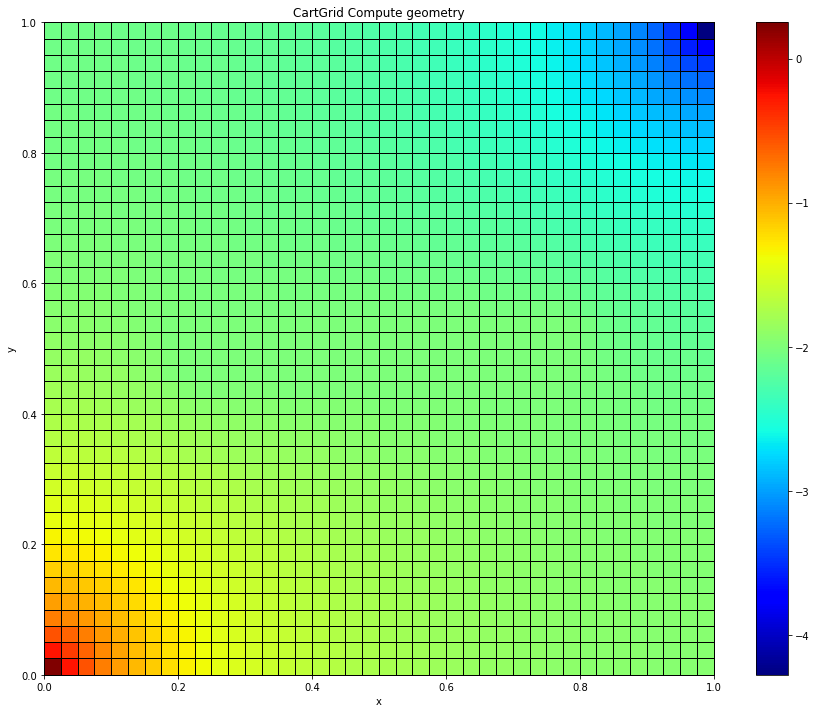

In [320]:
# Visualization
pp.plot_grid(g, p, figsize=(15, 12), plot_2d=True)

In [321]:
### Code copied from tutorials > single-phase_flow ###

solver_flow = pp.MVEM("flow")
solver_flow.discretize(g, data)
A, b_flow = solver_flow.assemble_matrix_rhs(g, data)

solver_rhs = pp.DualScalarSource("flow")

data[pp.PARAMETERS]["flow"]["source"] = data[pp.PARAMETERS]["flow"]["source"]
solver_rhs.discretize(g, data)
_, b_rhs = solver_rhs.assemble_matrix_rhs(g, data)

up = sps.linalg.spsolve(A, b_flow+b_rhs)                                              

# Extract the normal flux and pressure from the solution
u_mvem = solver_flow.extract_flux(g, up, data)
p_mvem = solver_flow.extract_pressure(g, up, data) 

# For visualisation purpose project the flux on a vector piecewise constant field
P0u = solver_flow.project_flux(g, u_mvem, data)

In [322]:
def normalized(a, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)


P0u_normalized = normalized(P0u,0)*0.055

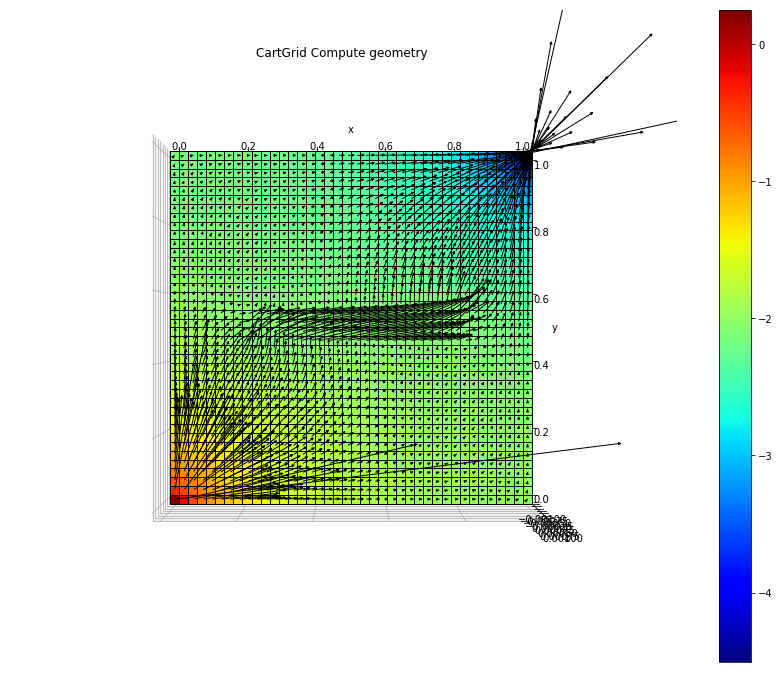

In [323]:
pp.plot_grid(g, p_mvem, P0u*0.035, figsize=(15, 12))